# PyTorch Workflow

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

#check the PyTorch version
torch.__version__

'2.1.2+cu121'

## Preparing the data

In [2]:
#create the known parameters
weight = 0.7 #m
bias = 0.3 #c

#creating the data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step)
y = weight * X + bias

X[10:],  y[10:]

(tensor([0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400, 0.3600,
         0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200, 0.5400,
         0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000, 0.7200,
         0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800, 0.9000,
         0.9200, 0.9400, 0.9600, 0.9800]),
 tensor([0.4400, 0.4540, 0.4680, 0.4820, 0.4960, 0.5100, 0.5240, 0.5380, 0.5520,
         0.5660, 0.5800, 0.5940, 0.6080, 0.6220, 0.6360, 0.6500, 0.6640, 0.6780,
         0.6920, 0.7060, 0.7200, 0.7340, 0.7480, 0.7620, 0.7760, 0.7900, 0.8040,
         0.8180, 0.8320, 0.8460, 0.8600, 0.8740, 0.8880, 0.9020, 0.9160, 0.9300,
         0.9440, 0.9580, 0.9720, 0.9860]))

In [3]:
#split the data into training and data
train = int(0.8 * len(X))
X_train, y_train = X[:train], y[:train]
X_test, y_test = X[train:], y[train:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [4]:
def plot_predictions(train_data = X_train,
                    train_label = y_train,
                    test_data = X_test,
                    test_label = y_test,
                    predictions = None):
    """ Plot training data, test data and compare predictions """

    plt.figure(figsize = (10,7))
    #plotting training data in blue
    plt.scatter(train_data, train_label, c='b', s=4, label = 'Training Data')
    #plotting test data in green
    plt.scatter(test_data, test_label, c='g', s=4, label = 'Test Data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label = 'Predictions')

    #Show the legend
    plt.legend(prop={"size": 14});

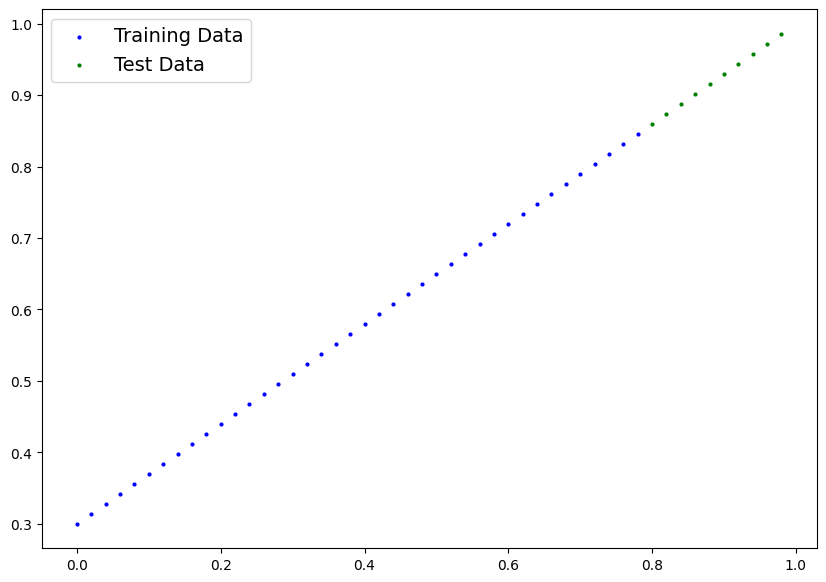

In [5]:
plot_predictions();

## Building the model

### What our model does:
* Start with random values (weight & bias)
* Look at the training data and find pattern in the data and adjust the random value to better represent(or get closer to) the ideal values (weight and bias that we used to create the data)

### How to do so?

Through main algorithms:
1. Gradient descent
2. Backpropagation

In [6]:
#create a linear regression model class (y = mx+c)
class LinearRegressionModel(nn.Module): # <- almost everything in Pytorch inherits from nn.module
    def __init__(self): #defining constructor
        super().__init__()
        #creating weight
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad = True, #by default its true,
                                               dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                               requires_grad = True, #by default its true,
                                               dtype = torch.float))
        #Use forward method to define computation in model
    def forward(self, x:torch.Tensor) -> torch.Tensor: #using the x as an input
        return self.weights * x + self.bias #linear regression formula
        
        

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (neural network can be consicdered as a computational graph)
* torch.nn.Parameters - defines what parameters our model should try to learn or update, often a PyTorch layer from torch.nn will set this for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward ()
* torch.optim - this is where all the optimizers in PyTorch lives, they will help with the gradiant descent
* def forward() - all nn.Module subclasses require you to overwrite forward function to define the main computation of the model.

In [7]:
torch.manual_seed(42)

#create an instance of the model
model = LinearRegressionModel()

#check out the parameters
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

Let's see how well the model predicts `y_test` based on `X_test`

In [9]:
X_test

tensor([0.8000, 0.8200, 0.8400, 0.8600, 0.8800, 0.9000, 0.9200, 0.9400, 0.9600,
        0.9800])

In [10]:
#make predictions with model
with torch.inference_mode(): #inference mode turn off that gradient tracking, which makes inference faster
    y_preds = model(X_test)
y_preds

tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])

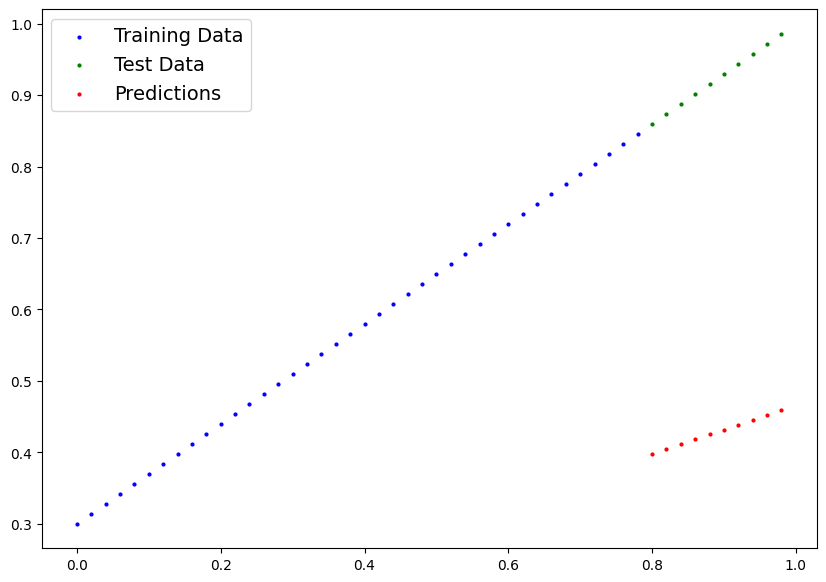

In [11]:
plot_predictions(predictions = y_preds) #without training

## Fitting the model to the data(Training)

* The whole idea of training a model is to move from some random parameters to some known parameters. Or in other word, poor representation of the data to better representation of the data
* We need to understand how poorly our model is performing, that's why we need a loss function/cost function/criterion.

*  **Loss Function:** A function that measures how your models are predicting compared to the ideal values, the lower the better.
*  **Optimizer:** Takes into account of the loss of the model, and adjust the model parameters

Specifically for PyTorch, we need:
* A training loop
* A testing loop

In [12]:
#set up a loss function
loss_fn = nn.L1Loss() #using mean absolute error as a loss function

#set up an optimizer
optimizer = torch.optim.SGD(model.parameters(), #using stochastic gradient descent as optimizer
                            lr = 0.01 #lr = learning rate, the most important hyperparameter in the training loop,
                           )


### Building a training loop

To buid a training loop:
1. Loop through the data
2. Forward pass, this refers to model's data going through model's forward function, this is called forward propagation.
3. Calculate the loss with the loss function
4. Optimier zero grad
5. Loss backkward - move backwards through the network to calculate gradients of each of the parameters of our model with respect to the loss.
6. Optimizer step - use optimizer to improve the loss by adjusting the model parameters (**gradient descent**)

In [13]:
#Building a training loop

#an epoch is one looop through the data
epochs = 100

#loop through the data
for epoch in range(epochs):
    
    #set the model to training mode
    model.train() #training mode set every parameter require gradients that require gradients, turs on gradient tracking

    #forward pass
    y_pred = model(X_train)

    #calculate the loss
    loss = loss_fn(y_pred, y_train) #input first, target next
    print(f"Loss: {loss}")
    
    #optimizer zero grad
    optimizer.zero_grad() #sets the optimizer to zero at the start of each loop

    #perform backpropagation
    loss.backward()

    #step the optimizer (perform graddint descent)
    optimizer.step() #how the optimizer changes will accumulate through the loop, so we have to zerro them before starting of the nect loop
    
    model.eval() #turns off setiings that are not needed for testing
    with torch.inference_mode():
        # 1. do the forward pass
        test_pred = model(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)
        
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Loss: {loss}| Test_loss: {test_loss}")
        print(model.state_dict())

Loss: 0.31288138031959534
Epoch: 0| Loss: 0.31288138031959534| Test_loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Epoch: 10| Loss: 0.1976713240146637| Test_loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Epoch: 20| Loss: 0.08908725529909134| Test_loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Loss: 0.08227583020925522
Loss: 0.07638

In [14]:
with torch.inference_mode():
    y_pred_new = model(X_test)

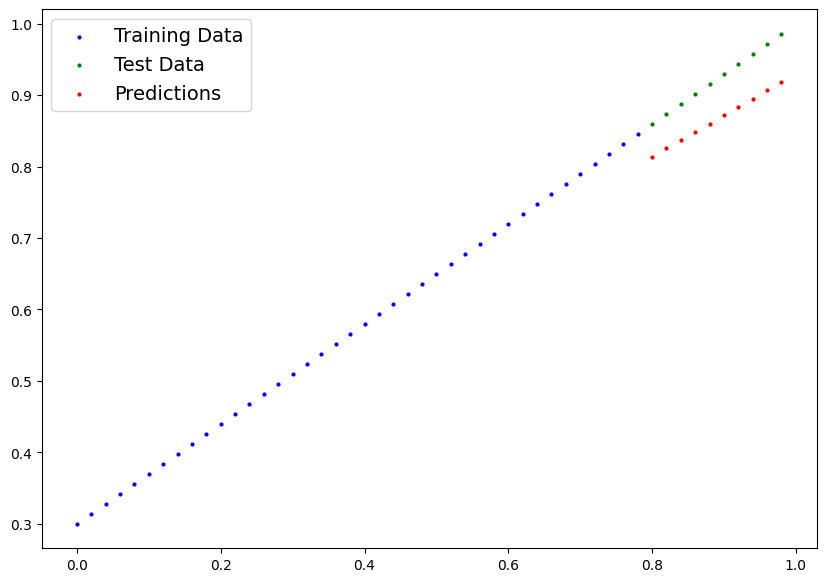

In [15]:
plot_predictions(predictions = y_pred_new)

## Making predictions and evaluating the model

## Saving and loading the model